In [52]:
%matplotlib inline

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision.models.vgg import model_urls
from collections import namedtuple
import torch.nn.init as init

In [54]:
def init_weights(modules):
  for m in modules:
    if isinstance(m, nn.Conv2d):
      init.xavier_uniform_(m.weight.data)
      if m.bias is not None:
        m.bias.data.zero_()
    elif isinstance(m, nn.BatchNorm2d):
      m.weight.data.fill_(1)
      m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
      m.weight.data.normal_(0, 0.01)
      m.bias.data.zero_()

[CRAFT General Architecture](https://miro.medium.com/max/2872/1*Bk8B872CriHl_DzrsW4SRQ.png!)

In [55]:
class Vgg16_bn(nn.Module):
  def __init__(self, pretrained = True, freeze = True):
    super(Vgg16_bn, self).__init__()
    #Replace the https url to http url
    model_urls['vgg16_bn'] = model_urls['vgg16_bn'].replace('https://', 'http://')
    # importing the vgg16_bn model available in pytorch
    # Since vgg16 returns feature of the model and the avgPool we are taking
    # features only

    vgg_pretrained = models.vgg16_bn(pretrained = pretrained)
    print(vgg_pretrained)

    # pretrained parameters emphasises if we are importing a already
    # trained model or not as the name suggests
    vgg_pretrained_features = models.vgg16_bn(pretrained = pretrained).features

    #Vgg is divided into 5 stages with last stage consisting of custom Linear model

    self.slice1 = nn.Sequential()
    self.slice2 = nn.Sequential()
    self.slice3 = nn.Sequential()
    self.slice4 = nn.Sequential()
    self.slice5 = nn.Sequential()

    # (h, w, 3) image
    for x in range(12):
      self.slice1.add_module(str(x), vgg_pretrained_features[x])
    
    # (h/4, w/4, 128)
    for x in range(12, 19):
      self.slice2.add_module(str(x), vgg_pretrained_features[x])

    # (h/8, w/8, 256)
    for x in range(19, 29):
      self.slice3.add_module(str(x), vgg_pretrained_features[x])

    #(h/16, w/16, 512)
    for x in range(29, 39):
      self.slice4.add_module(str(x), vgg_pretrained_features[x])

    #(h/32, w/32, 512)
    self.slice5 = nn.Sequential(
        nn.MaxPool2d(3, 1, 1),

        # dilation controls the spacing between the kernel points;
        # also known as the à trous algorithm.
        # (https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)
        
        nn.Conv2d(512, 1024, kernel_size = 3, padding=6, dilation = 6),
        nn.Conv2d(1024, 1024, kernel_size = 1)
    )

    # If a pretrained model is not being used
    # initalize weights to the vgg layers used
    if not pretrained:
      init_weights(self.slice1.modules())
      init_weights(self.slice2.modules())
      init_weights(self.slice3.modules())
      init_weights(self.slice4.modules())
      
    # weight initalization for custom Linear layer

    init_weights(self.slice5.modules())

      # since pytorch automatically does the backpropagration when called using
      # loss.backwards() So, here freezing indicates to not perfrom back propagation
      # for the first stage only

    if freeze:
      for param in self.slice1.parameters():
        param.requires_grad = False

      # For pyrotch every neural network must have a forward function
      # indicating the flow of the data in the network
      
  def forward(self, x):

      # Since the output of each stage will be required for another
      # custom CNN model they are saved for later used
        
    h = self.slice1(x)
    h_relu2_2 = h
    h = self.slice2(h)
    h_relu3_2 = h
    h = self.slice3(h)
    h_relu4_3 = h
    h = self.slice4(h)
    h_relu5_3 = h
    h = self.slice5(h)
    h_fc7 = h

    # namedtuple stores the data in the dictionary format and 
    # since they are ordered, they can be accessed via indices

    # For the next CNN the outputs of this VGG will be used in the reverse order
    # Hence, we are saving the outputs backward 
    vgg_outputs = namedtuple("VggOutputs", ['fc7', 'relu5_3', 'relu4_3', 'relu3_2', 'relu2_2'])
    out = vgg_outputs(h_fc7, h_relu5_3, h_relu4_3, h_relu3_2, h_relu2_2)

    return out


In [56]:
# Creating an upconv_block which consist of 2 convolutional layers
# with batch normalization. It is used in the creation of CRAFT
class UpConvBlock(nn.Module):
  def __init__(self, in_ch, mid_ch, out_ch):
    super(UpConvBlock, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_ch+ mid_ch, mid_ch, kernel_size = 1),
        nn.BatchNorm2d(mid_ch),
        nn.ReLU(inplace = True),
        nn.Conv2d(mid_ch, out_ch, kernel_size =3, padding = 1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace = True)
    )
  
  def forward(self, x):
    x = self.conv(x)
    return x

In [57]:
class CRAFT(nn.Module):
  print("reached craft")
  def __init__(self, pretrained = False, freeze = False):
    super(CRAFT, self).__init__()

    # base network i.e VGG16
    self.basenet = Vgg16_bn(True, True)

    #Up conv network i.e UpConvBlock
    self.upconv1 = UpConvBlock(1024, 512, 256)
    self.upconv2 = UpConvBlock(512, 256, 128)
    self.upconv3 = UpConvBlock(256, 128, 64)
    self.upconv4 = UpConvBlock(128, 64, 32)

    # we want region_score and affinity_score as an output
    num_class = 2

    self.conv_cls = nn.Sequential(
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(inplace = True),
        nn.Conv2d(32, 32, kernel_size = 3, padding = 1),
        nn.ReLU(inplace = True),
        nn.Conv2d(32, 16, kernel_size = 3, padding = 1),
        nn.ReLU(inplace = True),
        nn.Conv2d(16, 16, kernel_size = 1),
        nn.ReLU(inplace = True),
        nn.Conv2d(16, num_class, kernel_size = 1)
    )

    init_weights(self.upconv1.modules())
    init_weights(self.upconv2.modules())
    init_weights(self.upconv3.modules())
    init_weights(self.upconv4.modules())
    init_weights(self.conv_cls.modules())

  def forward(self, x):
    print("reached here")
    sources = self.basenet(x)
    
    # we are combining te output from slice4 and slice5
    y = torch.cat([sources[0], sources[1]], dim=1)
    y = self.upconv1(y)

    # data.size() and data.shape both returns the dimenison of the data
    y = F.interpolate(y, size = sources[2].size()[2:], mode = 'bilinear', align_corners = False)
    y = torch.cat([y, sources[2]], dim=1)
    y = self.upconv2(y)

    y = F.interpolate(y, size = sources[3].size()[2:], mode = 'bilinear', align_corners = False)
    y = torch.cat([y, sources[3]], dim = 1)
    y = self.upconv3(y)

    y = F.interpolate(y, size = sources[4].size()[2:], mode='bilinear', align_corners= False)
    y = torch.cat([y, sources[4]], dim = 1)

    # Since this output will be used for LinkRefiner
    feature = self.upconv4(y)

    out = self.conv_cls(feature)

    # out.permute aranges the output in the form of (no_of_images, width, heigth, channel)
    # since the pytoch NN uses the format of (no_of_images, channel, width, height)

    return out.permute(0, 2, 3, 1), feature




reached craft


In [58]:
# # Importing a CRAFT model
# from google.colab import files

# craft_model = files.upload()

In [59]:
from collections import OrderedDict
#OrderedDict is generally used for naming the layers of NN
def copyStateDict(state_dict):
  # "module.basenet.slice1.0.bias" or "basenet.slice1.0.bias"
  if list(state_dict.keys())[0].startswith("module"):
    start_idx = 1
  else:
    state_idx = 0

  new_state_dict = OrderedDict()
  
  for k, v in state_dict.items():
    name = ".".join(k.split(".")[start_idx:])
    new_state_dict[name] = v
  return new_state_dict

In [60]:
def get_detector(trained_model, device='cpu', quantize= True):

  model = CRAFT()

  # load the saved model
  if device == 'cpu':
    # map_location=torch.device('cpu') to map storage to cpu
    model.load_state_dict(copyStateDict(torch.load(trained_model, map_location=torch.device('cpu'))))

    # quantization helps to reduce the size of the weights or model by 
    # using lower precision integer representation. This saves the time
    # for interference

    if quantize:
      try:
        torch.quantization.quantize_dynamic(model, dtype=torch.qint8, inplace = True)
      except:
        pass
    
  else:
    
    # we will focus on the cpu for now only
    pass

  # In order to not perform the dropout, batchnormalization eval() is used
  # Mainly done during testing phase
  model.eval()
  return model


In [61]:
# detector = get_detector('/content/craft_mlt_25k.pth')
detector = get_detector('/content/drive/MyDrive/craft_mlt_25k.pth')

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [62]:
detector

CRAFT(
  (basenet): Vgg16_bn(
    (slice1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (slice2): Sequential(
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kerne

In [63]:
import cv2
from skimage import io
import sys
import os
import numpy as np
from logging import getLogger

if sys.version_info[0] == 2:
    from six.moves.urllib.request import urlretrieve
else:
    from urllib.request import urlretrieve

LOGGER = getLogger(__name__)


def loadImage(image):
    img = io.imread(image)
    if img.shape[0] == 2:
        img = img[0]

    # If image has gray colorspace convert it into rgb
    if len(img.shape) == 2:
        img = cv2.cvtCOLOR(img, cv2.COLOR_GRAY2RGB)

    # If image is an RGBA color space convert it to RGB
    if img.shape[2] == 4:
        img = img[:, :, :3]
    img = np.array(img)
    return img

# Returns RGB and gray image after reading them


def reformat_image(image):
    if type(image) == str:
        # Download image if url is provided
        if image.startswith('https://') or image.startswith('http://'):
            file_name, header = urlretrieve(image)
            img_cv_gray = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
            os.remove(file_name)
        else:
            # Read image if path is given
            img_cv_gray = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
            image = os.path.expanduser(image)
        img = loadImage(image)

        # If image is in buffer and is of bytes type then read it
    elif type(image) == bytes:
        # Read buffer as an array
        nparr = np.frombuffer(image, np.unit8)
        # cv2.imdecode() function reads data from specified memory cache
        # and converts (decodes) data into image format
        img = np.imdecode(nparr, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_cv_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # If image in a form a ndarray is provided
    elif type(image) == np.ndarray:

        # If ndarray is 2 dimensional
        if len(image.shape) == 2:
            img_cv_gray = image
            img = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # If ndarray is 3 dimensional and 3rd dimensional value is 3
        elif len(image.shape) == 3 and image.shape[2] == 3:
            img = image
            img_cv_gray = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # If ndarray is 3 dimensional and 3rd dimensional value is 4
        # convert the 3rd dimensional value to 3
        elif len(image.shape) == 3 and image.shape[2] == 4:
            img = image[:, :, :3]
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Why BGR???
            img_cv_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        LOGGER.warning("Invalid input type.")
        img = image
        img_cv_gray = image

    return img, img_cv_gray


In [64]:
!pip install pillow
from PIL import Image

In [65]:
def resize_aspect_ratio(img, square_size, interpolation, mag_ratio=1):
  print(img.shape)
  # io.imshow(img)
  height, width, channel = img.shape

  max_dim = max(width, height)

  target_size = mag_ratio * max_dim

  if target_size > square_size:
    target_size = square_size
  
  ratio = target_size/max_dim

  target_h, target_w = int(height * ratio), int(width * ratio)

  resized_img = cv2.resize(img, (target_w, target_h), interpolation = interpolation)
  # io.imshow(resized_img)

  # Creating a canvas in order to add the text area image
  target_h32, target_w32 = target_h, target_w
  if target_h % 32 != 0:
    target_h32 = target_h + (32 - target_h % 32)
  if target_w % 32 != 0:
    target_w32 = target_w + (32 - target_w % 32)
  
  #Create canvas with 0 values
  canvas = np.zeros((target_h32, target_w32, channel), dtype=np.float32)
  canvas[0:target_h, 0:target_w, :] = resized_img

  # If we want to view the canvas
  # Since the values are in float they need to be convert to uint8
  img = Image.fromarray(canvas.astype(np.uint8), "RGB")
  img.save("canvas.png")

  target_h, target_w = target_h32, target_w32

  size_heatmap = (int(target_w/2), int(target_h/2))
  
  return canvas, ratio, size_heatmap

 

In [66]:
def normalizeMeanVariance(in_img, mean=(0.485, 0.456, 0.406), variance = (0.229, 0.224, 0.225)):
  
  # the values of images need to be in float since division results in the float
  img = in_img.copy().astype(np.float32)

  img -= np.array([mean[0] * 255.0, mean[1] * 255.0, mean[2] * 255.0])
  img /= np.array([variance[0] * 255.0, variance[1] * 255.0, variance[2] * 255.0])

  return img

In [67]:
def test_net(canvas_size, mag_ratio, net, image, text_threshold, link_threshold, low_text, poly, device, estimate_num_chars = False):
# def test_net(canvas_size, mag_ratio, net, image):
  img_resized, target_ratio, size_heatmap = resize_aspect_ratio(image, canvas_size, interpolation = cv2.INTER_LINEAR, mag_ratio = mag_ratio)
  ratio_h = ratio_w = 1/ target_ratio

  # preprocessing 
  x = normalizeMeanVariance(img_resized)
  # Since the image is in ndarray.numpy type it needs to be 
  # converted into a tensor
  x = torch.from_numpy(x).permute(2, 0, 1)  #(h, w, c) to (c, h, w)
  print(x.shape)
  x = torch.unsqueeze(x, dim = 0) #(c, h, w) to (b, c, h, w)
  print(x.shape)
  # for moving the information to cuda but will ignore for now
  # x = x.to(device)

  # prevents from perfroming back propagation
  with torch.no_grad():
    y, features = net(x)

  # shape fory is [1, 640, 1200, 2] where the last value 2 is for affinty and score
  score_test= y[0,:,:,0].cpu().data.numpy()
  score_link = y[0, :, :,1].cpu().data.numpy()

  getDetBoxes(textmap = score_test, linkmap=score_link, text_threshold = text_threshold, link_threshold = link_threshold, low_text = low_text, poly = poly, estimate_num_chars= estimate_num_chars)
  return y, features

  

In [68]:
def getDetBoxes(textmap, linkmap, text_threshold, link_threshold, low_text, poly = False, estimate_num_chars = False):
  if poly and estimate_num_chars:
    raise Exception("error")
  
  getDetBoxes_core(textmap, linkmap, text_threshold, link_threshold, low_text, estimate_num_chars)

In [69]:
import matplotlib.pyplot as plt
def getDetBoxes_core(textmap, linkmap, text_threshold, link_threshold, low_text, estimate_num_chars = False):

  #prepare data
  print(textmap.shape)
  
  plt.figure(figsize = (250, 100))
  plt.subplot(1,2, 1)
  io.imshow(textmap)

  plt.subplot(1, 2, 2)
  io.imshow(linkmap)
  
  # Creating a copy for affninty and region score so the original values are not affected
  linkmap1 = linkmap.copy()
  textmap1 = textmap.copy()
  img_h, img_w = textmap.shape

  # Binzarization
  """ labelling method ???""" 
  ret, text_score = cv2.threshold(textmap1, text_threshold, 1, 0)
  ret, link_score = cv2.threshold(linkmap1, link_threshold, 1, 0)
  
  print("After binarization")
  plt.figure(figsize = (250, 100))
  plt.subplot(1, 2, 1)
  io.imshow(text_score)

  plt.subplot(1, 2, 2)
  io.imshow(link_score)
  
  # Convert values less than 0 to 0 and value greater than 1 to 1
  text_score_comb = np.clib(texts_score + link_score, 0, 1)
  nLabels, labels, stats, centroids = cv2.connecte

In [70]:
# uploaded_image = files.upload()

In [71]:
img, gray_image = reformat_image("/content/drive/MyDrive/download.jpg")

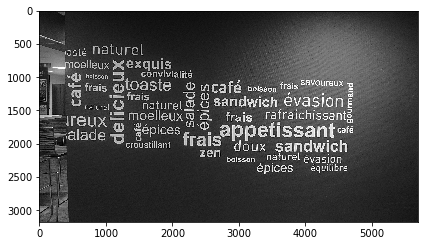

In [72]:
io.imshow(img)

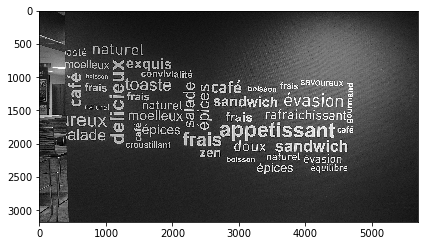

In [73]:
io.imshow(gray_image)

In [74]:
def get_textbox(detector, image, canvas_size, mag_ratio, text_threshold, link_threshold, low_text, poly, device, optimal_num_chars= None):
  result = []
  estimate_num_chars = optimal_num_chars is not None
  y, features= test_net(canvas_size, mag_ratio, detector, image, text_threshold, link_threshold, low_text, poly, device, estimate_num_chars)
# y, features= test_net(canvas_size = 2500, mag_ratio = 1, net = detector, image = img)



In [75]:
def detect(img, min_size = 20, text_threshold = 0.7, low_text = 0.4,\
           link_threshold = 0.4, canvas_size = 2560, mag_ratio = 1.,\
           slopw_ths = 0.1, ycenter_ths = 0.5, height_ths = 0.5,\
           width_ths = 0.5, add_margin = 0.1, reformat = True, optimal_num_chars = None):
  text_box = get_textbox(detector, img, canvas_size, mag_ratio, text_threshold, link_threshold, low_text,\
                         False, "cpu", optimal_num_chars)

In [76]:
detect(img)

(3176, 5688, 3)
torch.Size([3, 1440, 2560])
torch.Size([1, 3, 1440, 2560])
reached here
(720, 1280)


/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


After binarization
